In [8]:
import nibabel
import os
from pathlib import Path
import numpy as np

In [8]:
def parse_labels(raw_csv_file, output_file):
    
    import csv
    csv_columns = ['run','trial','global time', 'run time', 'morph level', 'couple', 'response', 'response time']
    csv_file = output_file
    
    f = open(raw_csv_file)
    all_lines = f.readlines()
    
    to_be_added = []
    morph_level = None
    couple = None
    is_complete = False
    new_morph = False
    nb_item = 0
    nb_run = 0
    first_morph = True
    
    def get_indices(all_lines, to_find='Debut_run '):
        indices = []
        for count, line in enumerate(all_lines):
            if line.find(to_find) > -1:
                indices += [count]
        return indices + [len(all_lines)]
    
    run_starts = get_indices(all_lines, 'Debut_run ')
    
    for nb_run in range(len(run_starts) - 1):
        
        run_start = run_starts[nb_run]
        run_stop = run_starts[nb_run + 1]
        
        sub_lines = all_lines[run_start:run_stop]
        
        syncro_line = get_indices(sub_lines, 'Synchro_IRM')
        global_t_start = int(sub_lines[syncro_line[0]].split(',')[0])

        morph_starts = get_indices(sub_lines, 'MORPH')
        
        for nb_item in range(len(morph_starts)-1):
        
            morph_start = morph_starts[nb_item]
            morph_stop = morph_starts[nb_item + 1]
            response = 0
            response_time = None
        
            for line in sub_lines[morph_start:morph_stop]:
                if line.find('morph_') > -1:
                    file_name = line.split(',')[3].split(' ')[1]
                    file_name = file_name.split("\\")[2]
                    morph_level = int(file_name.split('_')[1])
                    couple = int(file_name.split('_')[2].split('.')[0])
                    t_start = int(line.split(',')[3].split(' ')[2])

                if line.find('bouton_1') > -1:
                    response = 1
                    response_time = int(line.split(',')[3].split(' ')[1]) + 500

            to_add = {'run' : nb_run + 1, 
                      'trial' : nb_item + 1,
                       'global time' : t_start, 
                       'run time' :  t_start - global_t_start,
                       'morph level' : morph_level,
                       'couple' : couple, 
                       'response' : response, 
                       'response time' : response_time}
            to_be_added += [to_add]

    try:
        with open(output_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
            writer.writeheader()
            for data in to_be_added:
                writer.writerow(data)
    except IOError:
        print("I/O error")

In [ ]:
import os
for file in os.listdir(Path("labels/raw")):
    parse_labels(Path("labels/raw") / file, Path("labels") / file)

In [11]:
def view_results(subject=1, run='all', return_data=False):

    import pandas
    from pathlib import Path

    labels = pandas.read_csv(f'labels/labels_{subject}.csv')
    
    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
        T = labels['couple']
    elif run in range(1, 5):
        mask = labels['run'] == run
        x = labels[mask]['morph level']
        y = labels[mask]['response']
        z = labels[mask]['response time']
        T = labels[mask]['couple']
    
    import pylab as plt
    values, counts = np.unique(x, return_counts=True)

    results = {}
    results['response'] = {'mean' : np.zeros(len(values)), 'std' : np.zeros(len(values))}
    results['response_time'] = {'mean' : np.zeros(len(values)), 'std' : np.zeros(len(values))}
    for count, v in enumerate(values):
        mask = (x == v)
        results['response']['mean'][count] = np.nan_to_num(np.mean(y[mask]))
        results['response']['std'][count] = np.nan_to_num(np.std(y[mask])/np.sqrt(np.sum(mask)))

        results['response_time']['mean'][count] = np.nan_to_num(np.mean(z[mask]))
        results['response_time']['std'][count] = np.nan_to_num(np.std(z[mask])/np.sqrt(np.sum(mask)))

    fig, ax = plt.subplots(ncols=2, squeeze=False, figsize=(15,5))
    ax[0,0].plot(values, results['response']['mean'])
    ax[0,0].fill_between(values, results['response']['mean'] - results['response']['std'], 
                     results['response']['mean'] + results['response']['std'], alpha=0.25)
    ax[0,0].set_xlabel('% morph')
    ax[0,0].set_ylabel('response')
    ax[0,0].set_title(f'Subject {subject}')
    ax[0,0].set_xlim(0, 100)

    ax[0,1].plot(values, results['response_time']['mean'])
    ax[0,1].fill_between(values, results['response_time']['mean'] - results['response_time']['std'], 
                     results['response_time']['mean'] + results['response_time']['std'], alpha=0.25)
    ax[0,1].set_xlabel('% morph')
    ax[0,1].set_ylabel('response time (ms)')
    ax[0,1].set_xlim(0, 100)
    
    if return_data:
        return results
    

{'response': {'mean': array([0.12195122, 0.05405405, 0.06060606, 0.11904762, 0.16216216,
         0.42857143, 0.77142857, 0.8       , 0.82352941, 0.81578947]),
  'std': array([0.05110466, 0.03717461, 0.04153603, 0.0499703 , 0.06059739,
         0.08364858, 0.07097817, 0.06761234, 0.0653787 , 0.06288607])},
 'response_time': {'mean': array([2666.        , 2044.        , 2563.5       , 2703.8       ,
         1756.33333333, 1201.93333333, 1135.62962963,  988.07142857,
          855.39285714,  854.41935484]),
  'std': array([243.23955872,  54.58046379, 188.78721788, 185.79380276,
         188.62089981, 105.22794245, 161.22929315, 142.07015318,
          62.56236115,  90.448794  ])}}

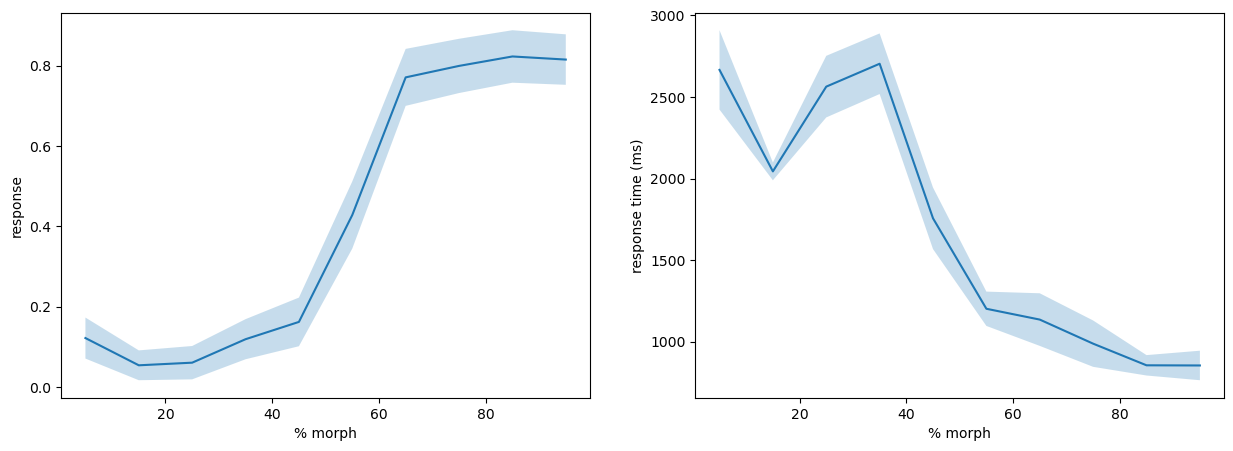

In [15]:
view_results(24,'all',return_data=True,do_plot=True)

{'response': {'mean': array([0.7027027 , 0.74285714, 0.79487179, 0.85294118, 0.92105263,
         0.90625   , 0.775     , 0.91428571, 0.90625   , 0.85365854]),
  'std': array([0.0751416 , 0.07387642, 0.06465899, 0.06073872, 0.04374408,
         0.05152698, 0.06602556, 0.04731878, 0.05152698, 0.05519934])},
 'response_time': {'mean': array([ 715.96153846,  817.92307692, 1010.77419355,  724.31034483,
          762.85714286,  805.06896552,  716.5483871 ,  710.46875   ,
          852.79310345,  702.25714286]),
  'std': array([ 53.22375552,  56.11085815, 132.78130997,  32.35434214,
          29.10396565,  97.46471434,  30.4603613 ,  32.06410945,
         111.85094742,  31.95339251])}}

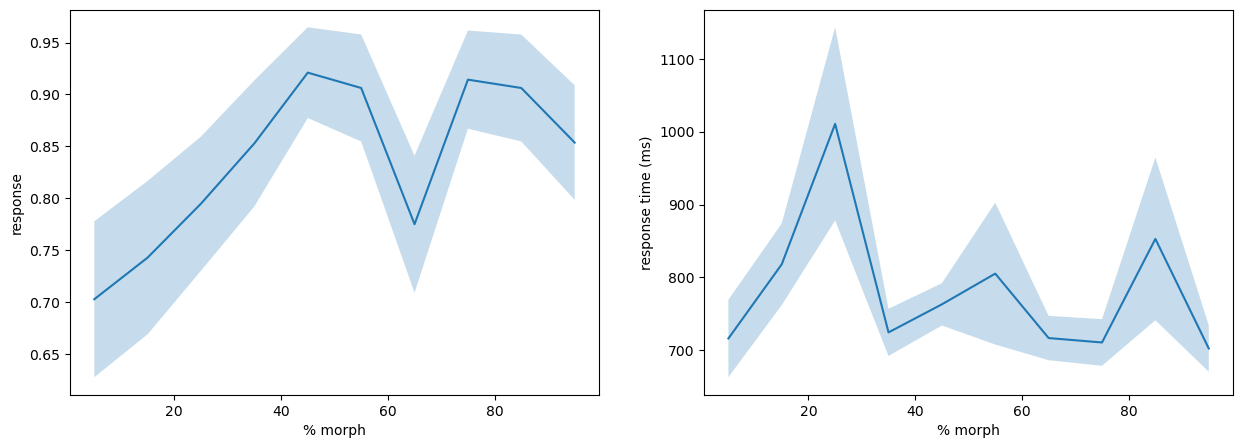

In [14]:
view_results(9,'all',return_data=True,do_plot=True)

{'response': {'mean': array([0.04761905, 0.02564103, 0.09090909, 0.16666667, 0.18604651,
         0.31578947, 0.5       , 0.5       , 0.66666667, 0.63888889]),
  'std': array([0.03286026, 0.02531016, 0.05004381, 0.06804138, 0.05934393,
         0.07540531, 0.08574929, 0.08333333, 0.07548514, 0.08005378])},
 'response_time': {'mean': array([2955.        , 2761.        , 2097.66666667, 1566.2       ,
         1675.125     , 1127.08333333, 1129.64705882,  951.11111111,
         1014.        ,  904.39130435]),
  'std': array([108.16664832,   0.        ,  96.47706938, 179.82826622,
         162.71494617,  54.34802803,  72.50409704,  34.0400041 ,
          74.00083959,  20.06858645])}}

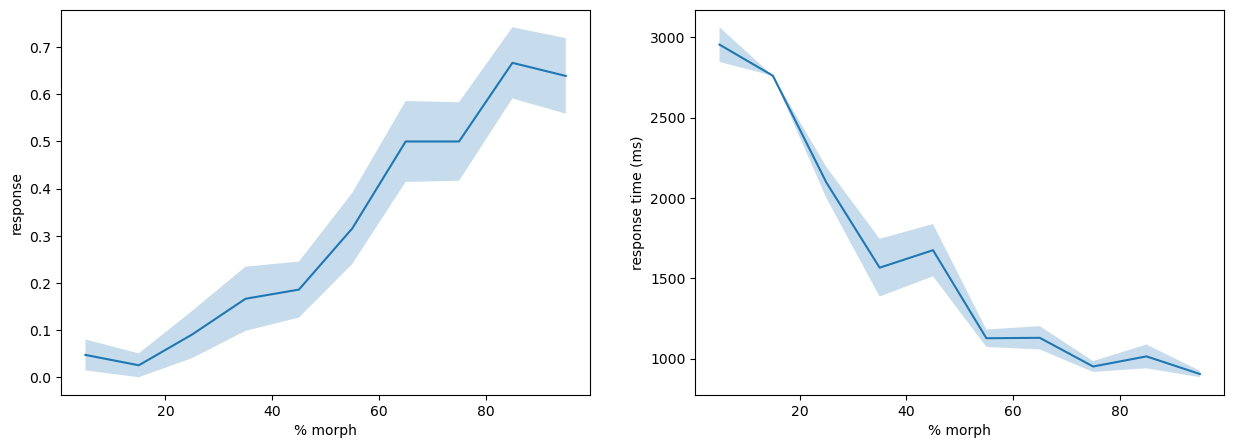

In [13]:
view_results(5,'all',return_data=True,do_plot=True)

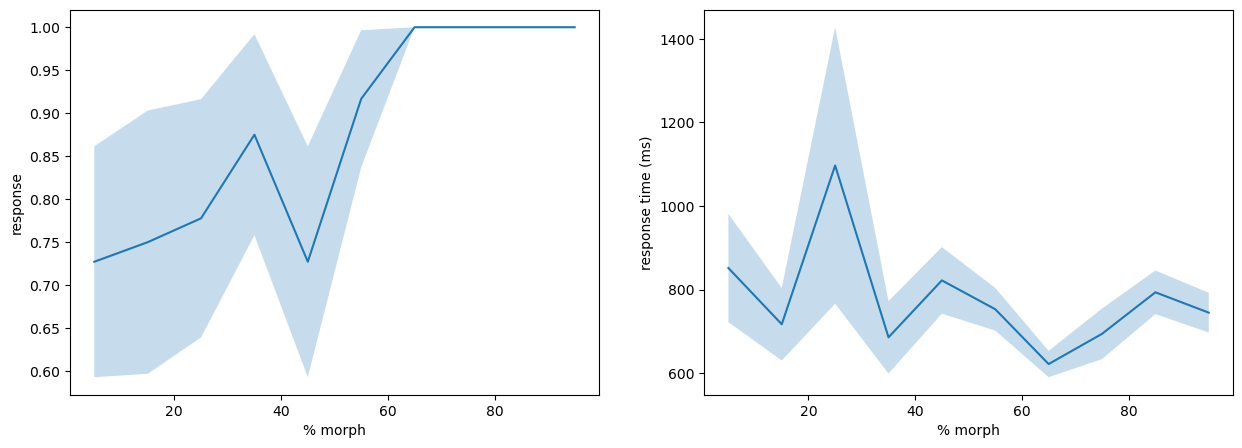

In [71]:
view_results(1,True)

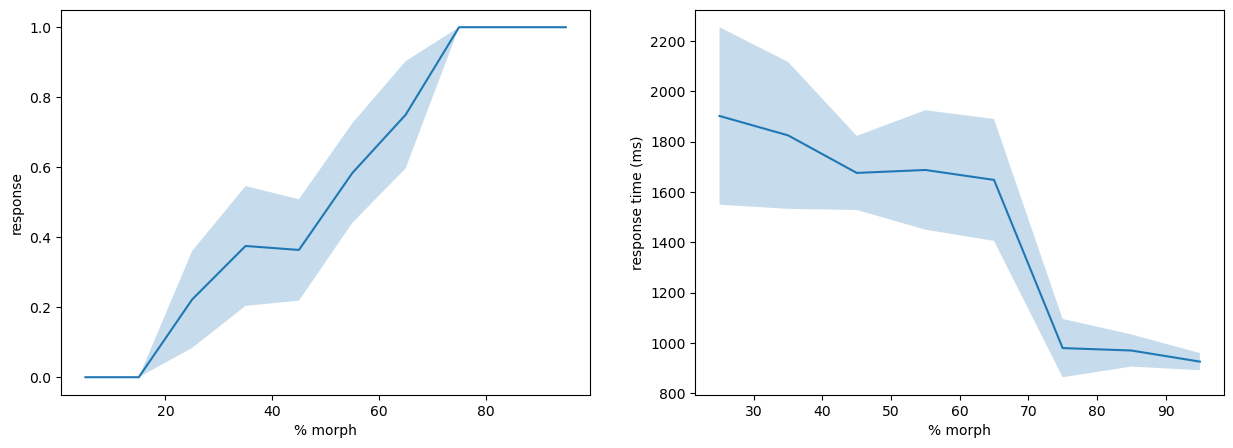

In [6]:
view_results(3,True)

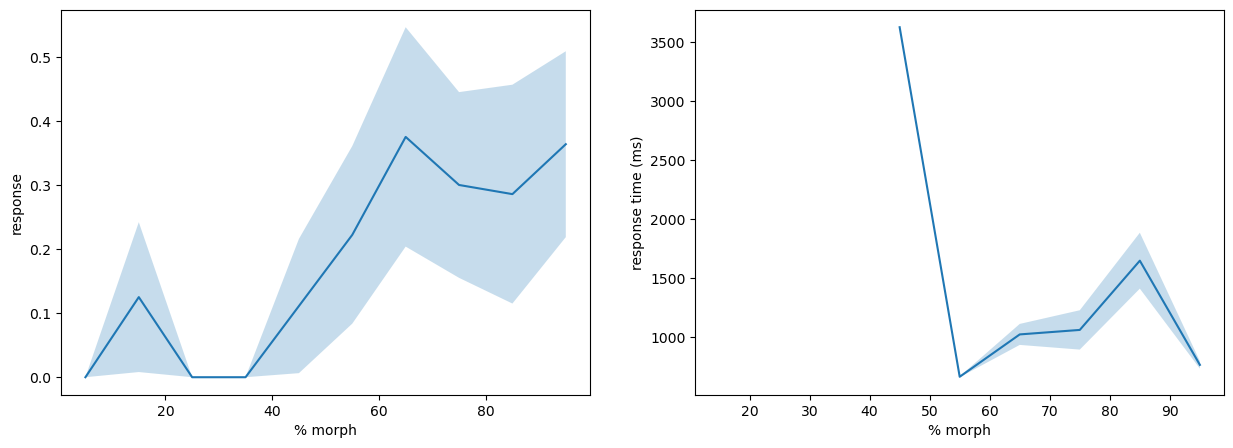

In [7]:
view_results(23,True)

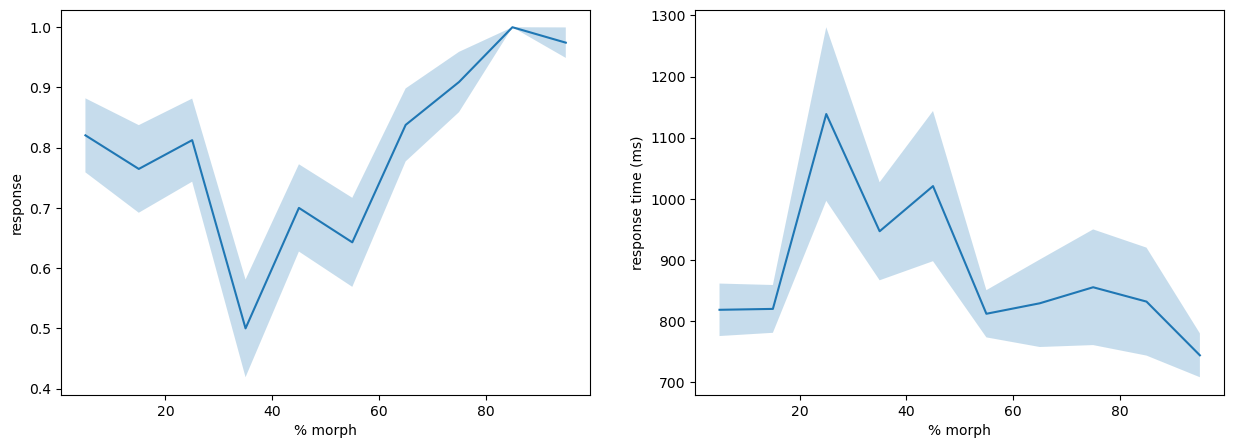

In [8]:
results = view_results(1, return_data=True)

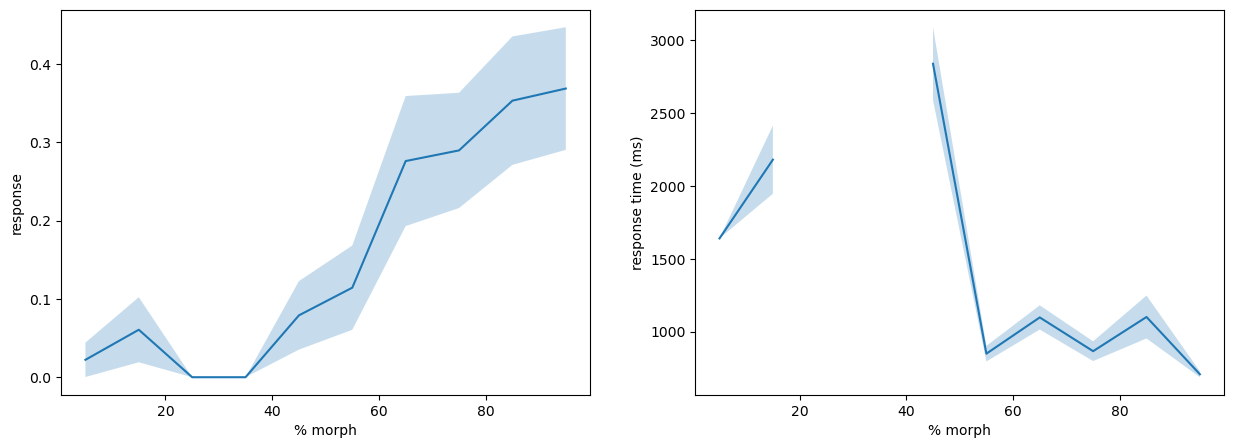

In [9]:
results = view_results(23, return_data=True)


(10,)
[1.0, 50.0, 1, 0.02127659574468085]


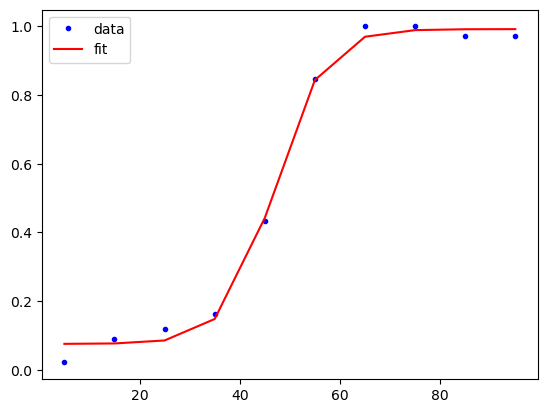

In [41]:
results = view_results(i, return_data=True, do_plot=False)
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# définir la fonction sigmoidale
def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y
xdata = np.linspace(5, 95, 10 )
print(xdata.shape)

ydata = results['response']['mean']

# ajuster la fonction sigmoidale aux données
p0 = [max(ydata), np.median(xdata), 1, min(ydata)]
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, )
print(p0)
# tracer les données et la courbe ajustée
plt.plot(xdata, ydata, 'b.', label='data')
plt.plot(xdata, sigmoid(xdata, *popt), 'r-', label='fit')
plt.legend()
plt.show()



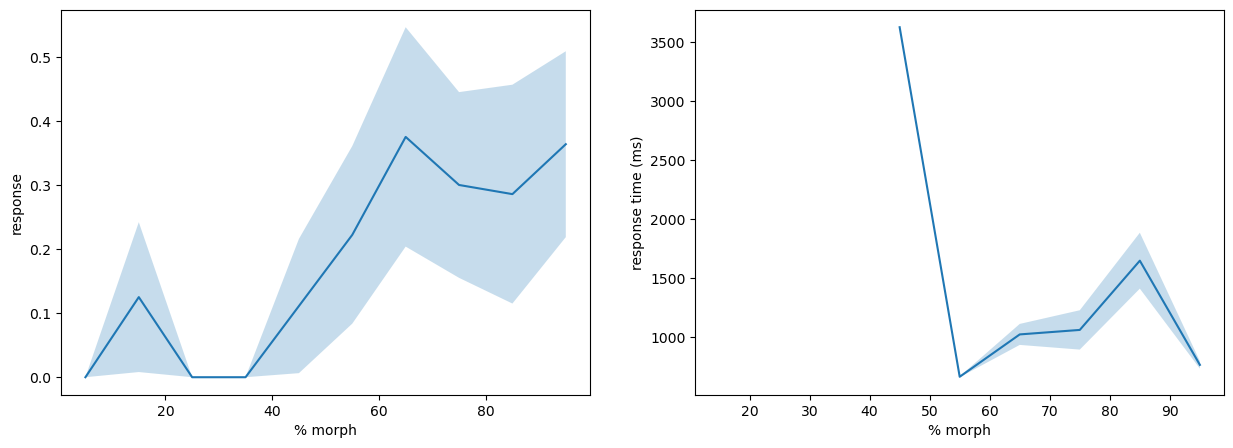

In [5]:
view_results(23,True,False)

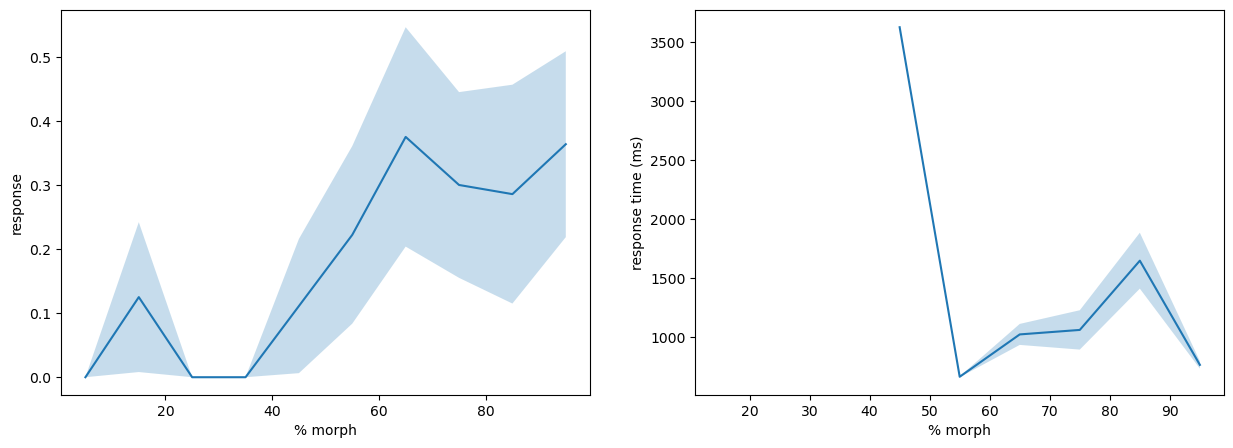

In [3]:
view_results(23,True,False)

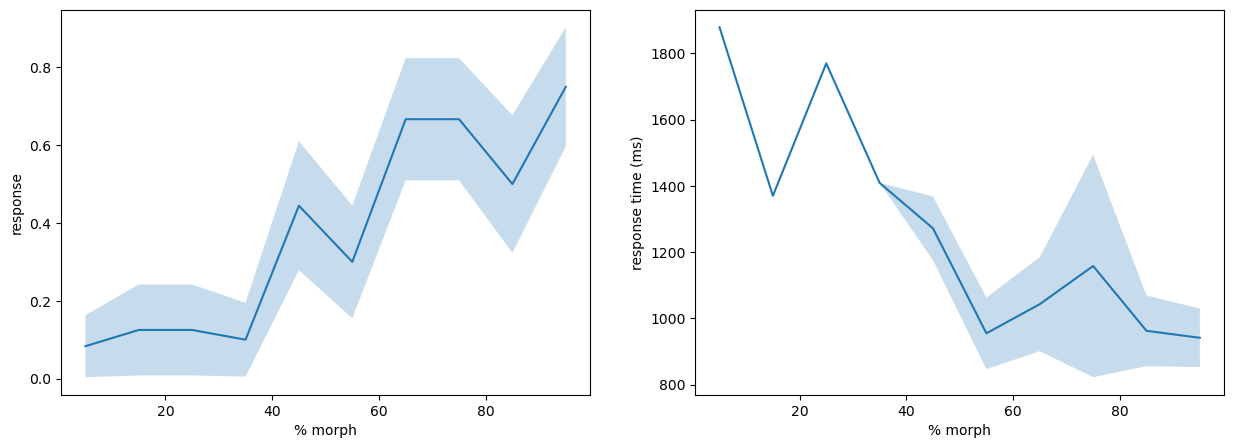

In [18]:
view_results(25,True,False)

(10,)
[1.0, 50.0, 1, 0.5]


C:\Users\Sofiane\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


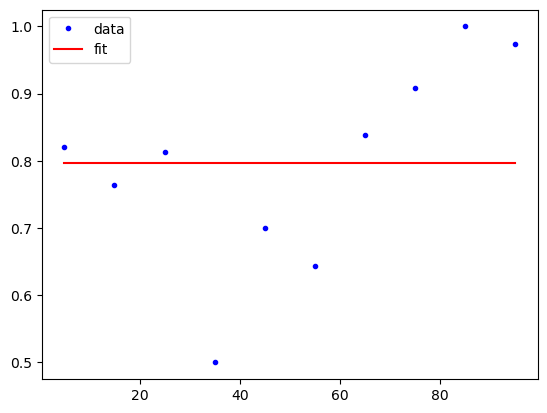

(10,)
[1.0, 50.0, 1, 0.30952380952380953]


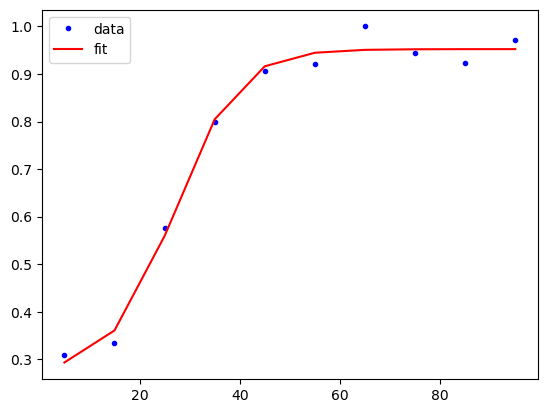

(10,)
[0.9444444444444444, 50.0, 1, 0.28205128205128205]


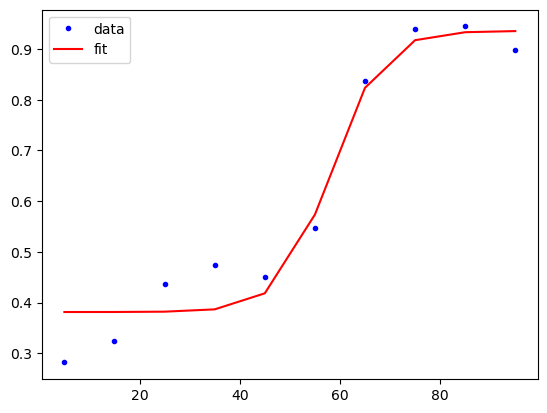

(10,)
[1.0, 50.0, 1, 0.525]


C:\Users\Sofiane\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


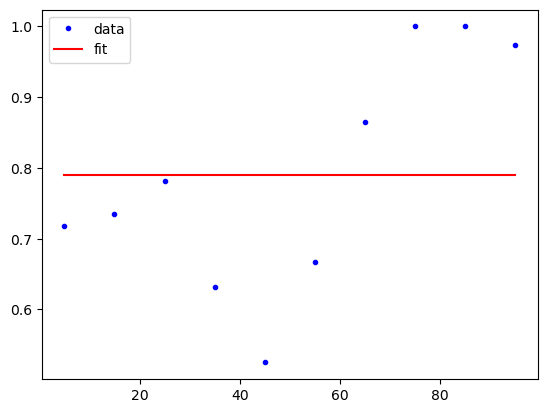

(10,)
[0.6666666666666666, 50.0, 1, 0.02564102564102564]


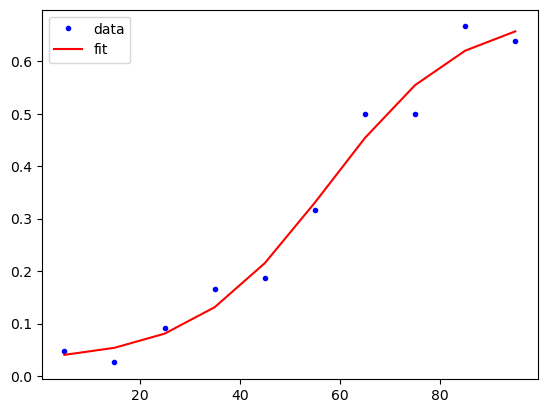

(10,)
[1.0, 50.0, 1, 0.025]


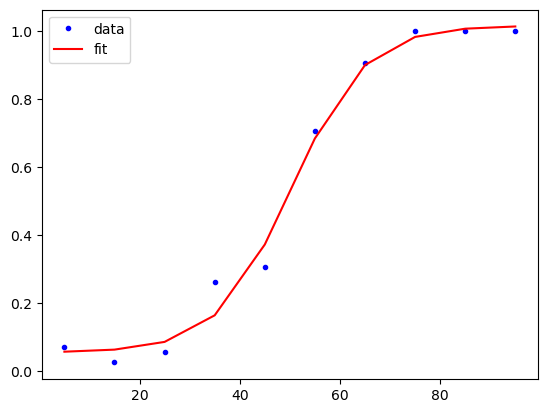

(10,)
[0.9743589743589743, 50.0, 1, 0.05263157894736842]


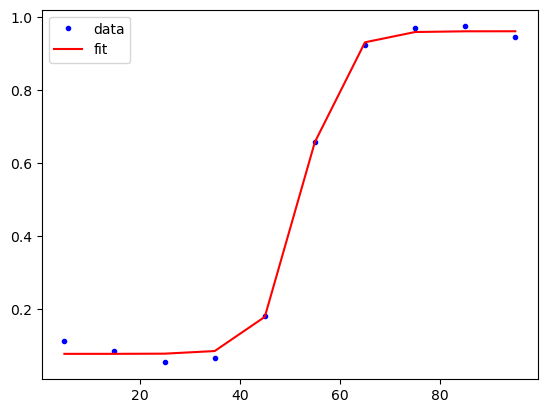

(10,)
[0.9487179487179487, 50.0, 1, 0.05128205128205128]


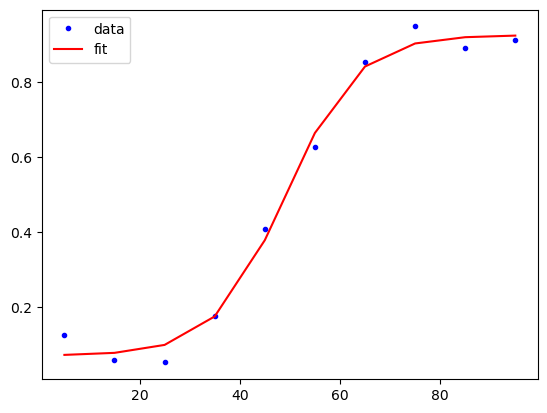

(10,)
[0.9210526315789473, 50.0, 1, 0.7027027027027027]


C:\Users\Sofiane\AppData\Local\Temp\ipykernel_75288\2260463801.py:8: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
C:\Users\Sofiane\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


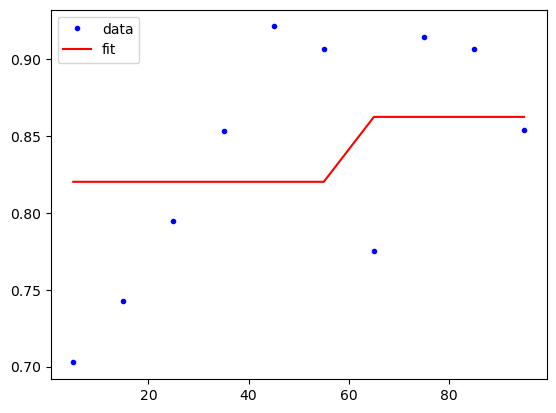

(10,)
[0.9487179487179487, 50.0, 1, 0.07894736842105263]


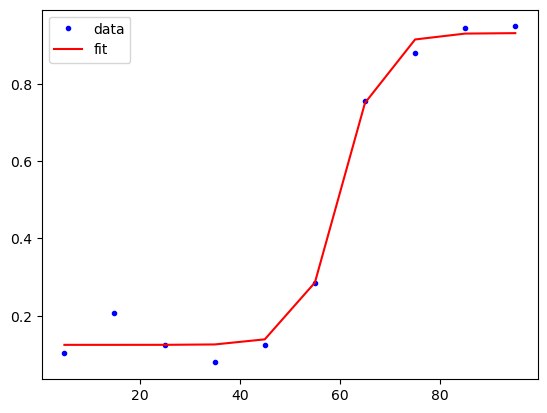

(10,)
[0.9444444444444444, 50.0, 1, 0.06060606060606061]


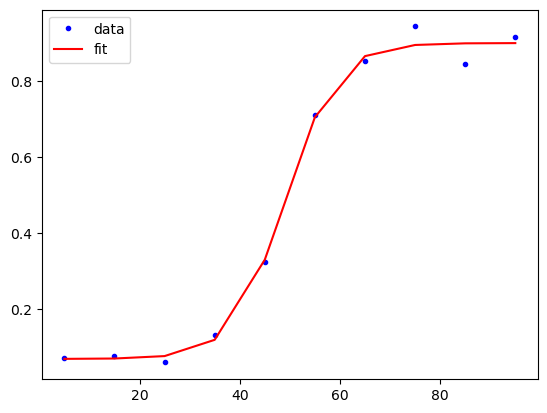

(10,)
[1.0, 50.0, 1, 0.0]


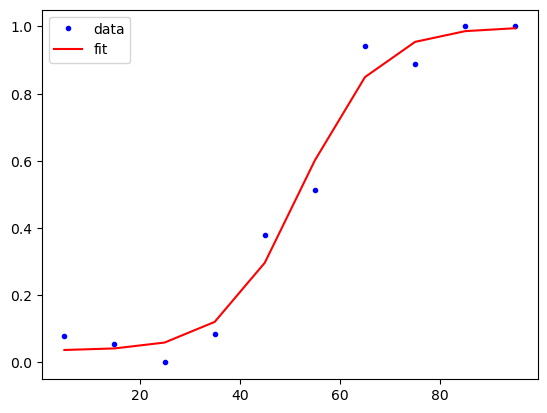

(10,)
[1.0, 50.0, 1, 0.02127659574468085]


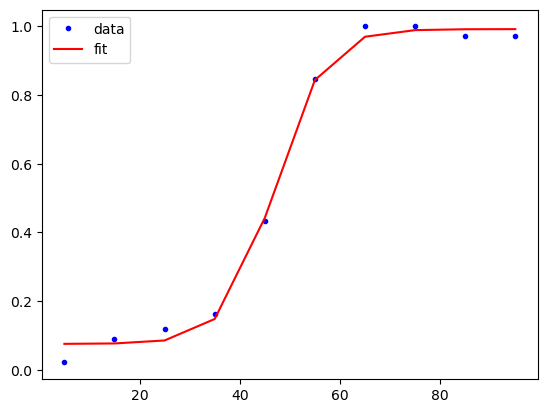

(10,)
[1.0, 50.0, 1, 0.027777777777777776]


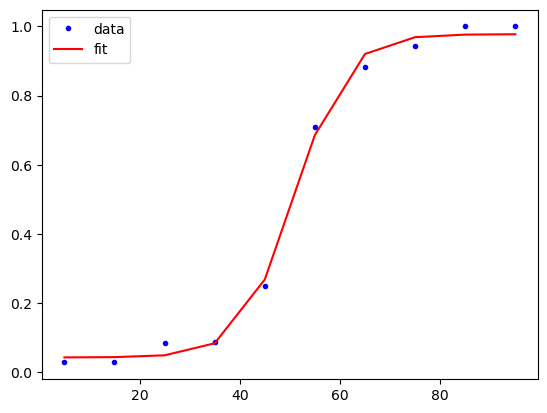

(10,)
[1.0, 50.0, 1, 0.06060606060606061]


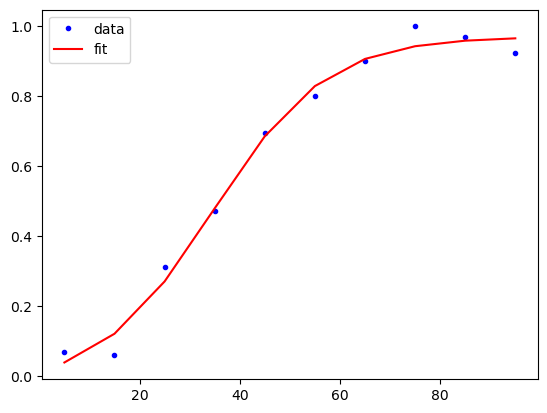

(10,)
[0.9743589743589743, 50.0, 1, 0.05263157894736842]


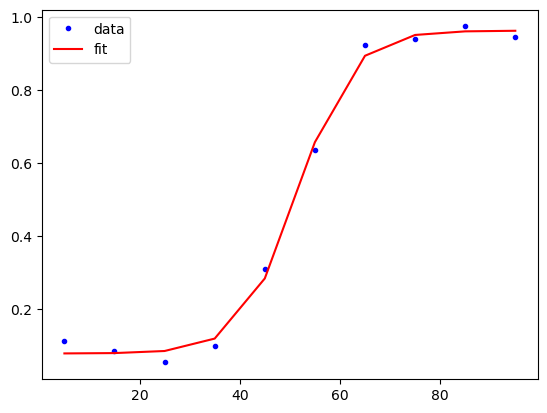

(10,)
[1.0, 50.0, 1, 0.25806451612903225]


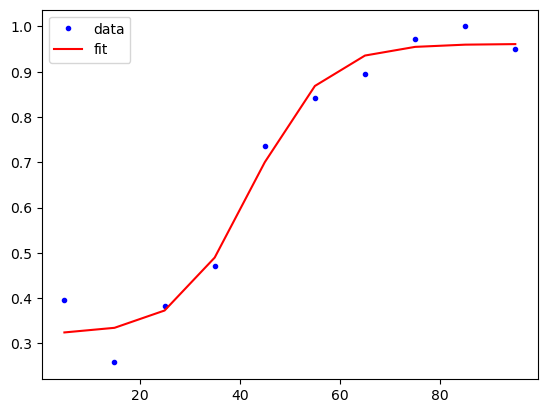

(10,)
[1.0, 50.0, 1, 0.02564102564102564]


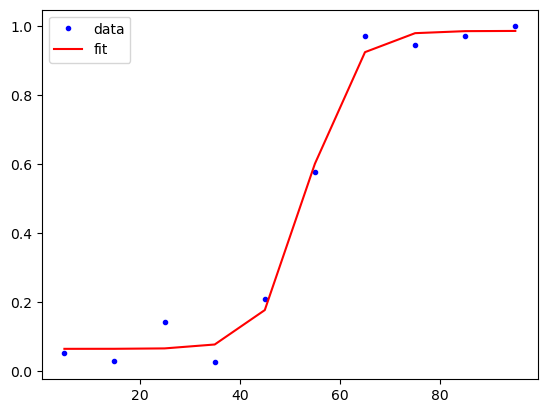

(10,)
[0.9459459459459459, 50.0, 1, 0.3181818181818182]


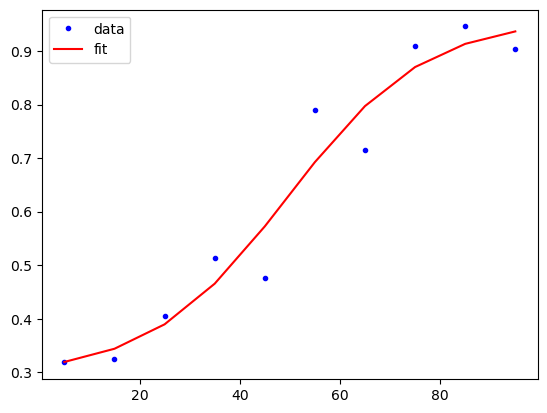

(10,)
[0.59375, 50.0, 1, 0.1951219512195122]


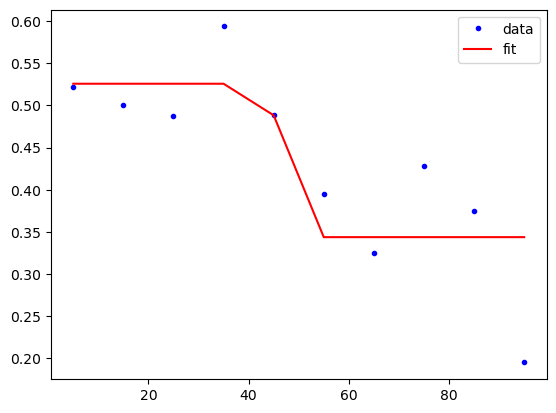

(10,)
[1.0, 50.0, 1, 0.0]


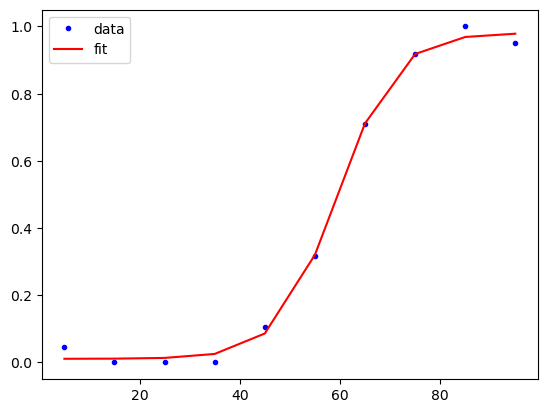

(10,)
[0.6756756756756757, 50.0, 1, 0.19444444444444445]


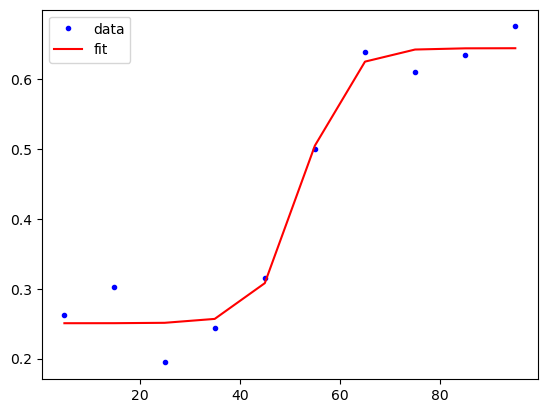

(10,)
[0.3684210526315789, 50.0, 1, 0.0]


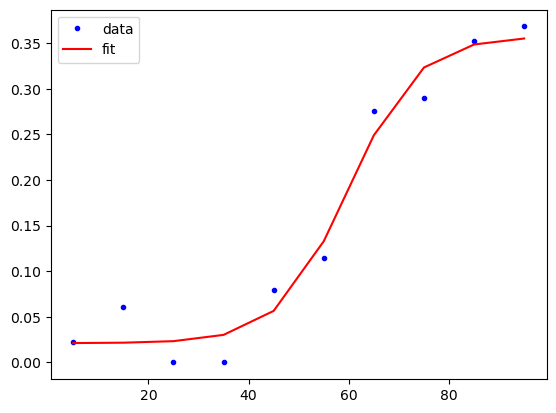

(10,)
[0.8235294117647058, 50.0, 1, 0.05405405405405406]


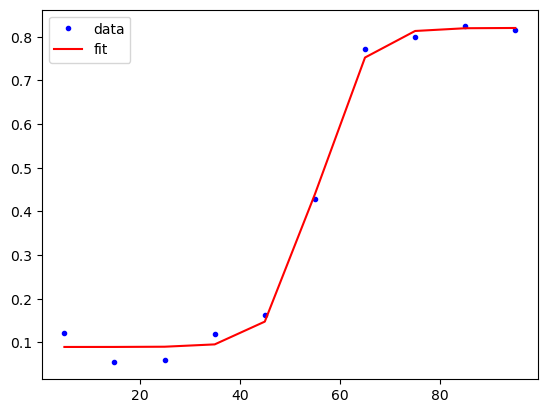

(10,)
[0.8823529411764706, 50.0, 1, 0.14634146341463414]


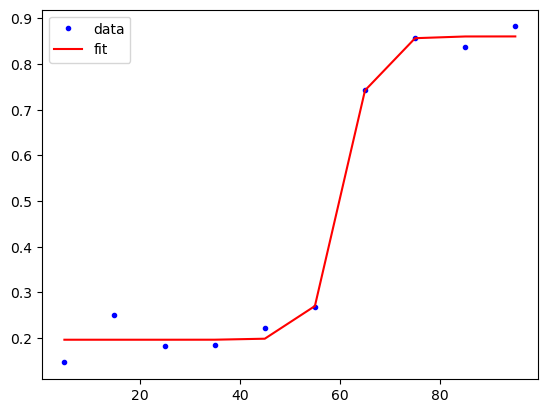

In [23]:
for i in range (1,26):     
    results = view_results(i, return_data=True, do_plot=False)
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

# définir la fonction sigmoidale
    def sigmoid(x, L, x0, k, b):
        y = L / (1 + np.exp(-k*(x-x0))) + b
        return y
    xdata = np.linspace(5, 95, 10 )
    print(xdata.shape)

    ydata = results['response']['mean']

# ajuster la fonction sigmoidale aux données
    p0 = [max(ydata), np.median(xdata), 1, min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, )
    print(p0)
# tracer les données et la courbe ajustée
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.plot(xdata, sigmoid(xdata, *popt), 'r-', label='fit')
    plt.legend()
    plt.show()


Seuil d'inflexion pour les données 1 : 105.35185278956784


C:\Users\Sofiane\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


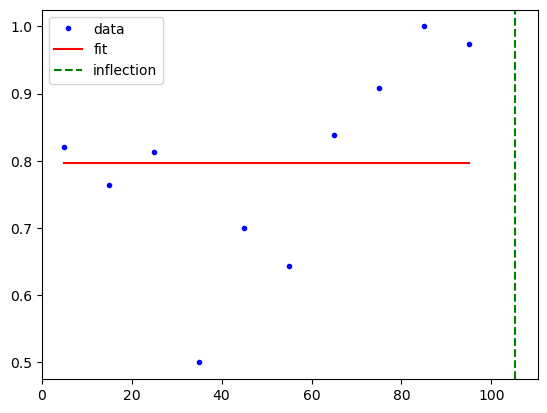

Seuil d'inflexion pour les données 2 : 26.996100054864463


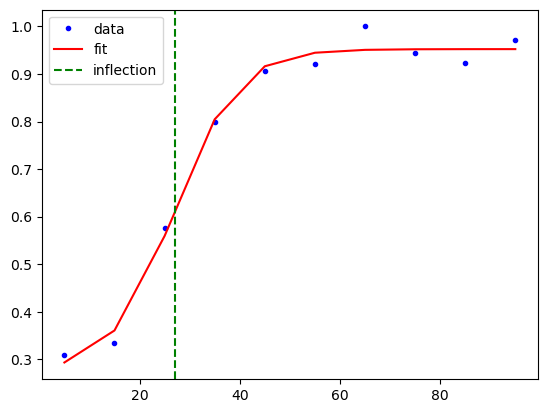

Seuil d'inflexion pour les données 3 : 58.16144435833213


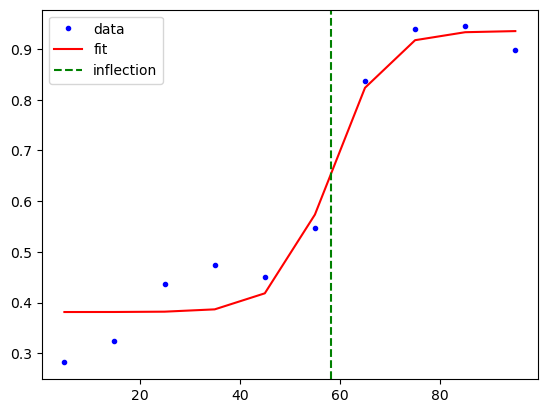

Seuil d'inflexion pour les données 4 : 103.07775210488234


C:\Users\Sofiane\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


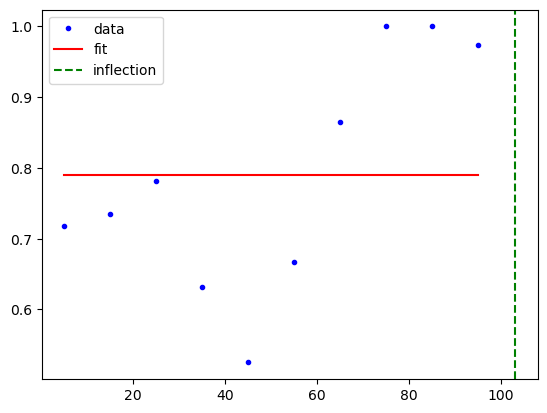

Seuil d'inflexion pour les données 5 : 57.39773911082459


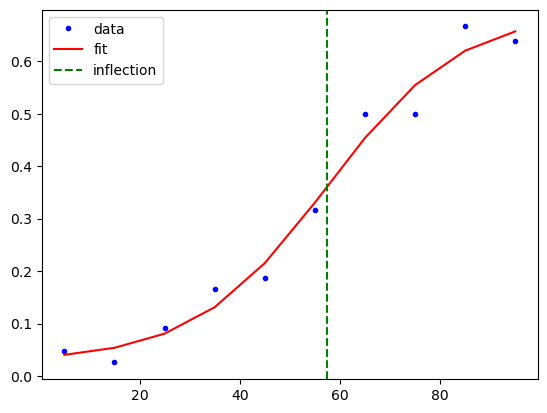

Seuil d'inflexion pour les données 6 : 50.24409872350616


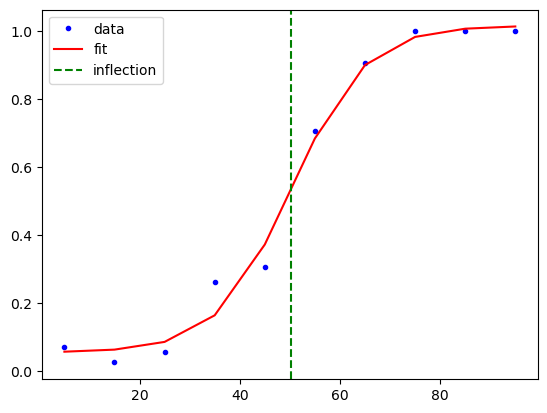

Seuil d'inflexion pour les données 7 : 52.59077215931989


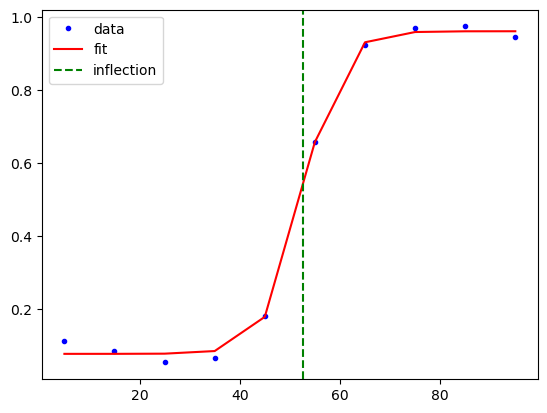

Seuil d'inflexion pour les données 8 : 49.12067042332128


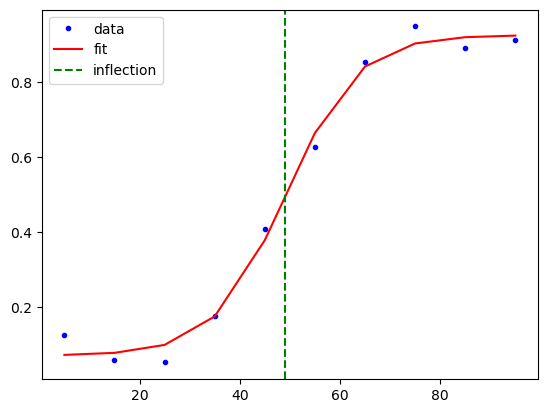

Seuil d'inflexion pour les données 9 : 58.980972609866086


C:\Users\Sofiane\AppData\Local\Temp\ipykernel_75288\1239749433.py:7: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b
C:\Users\Sofiane\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


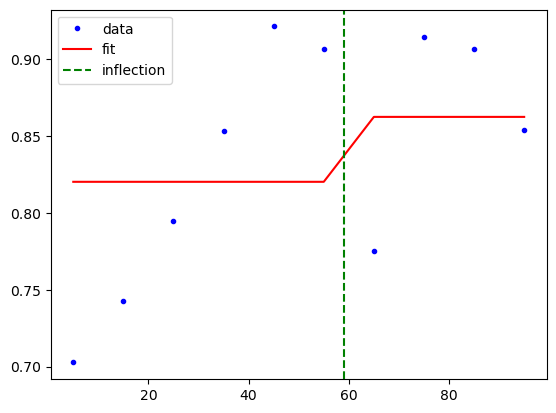

Seuil d'inflexion pour les données 10 : 60.273651207671016


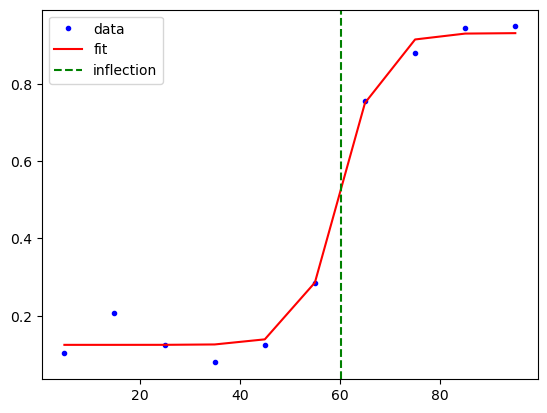

Seuil d'inflexion pour les données 11 : 48.97784573003228


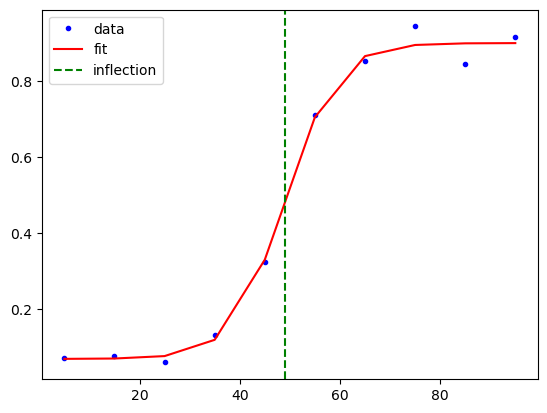

Seuil d'inflexion pour les données 12 : 52.34360302255799


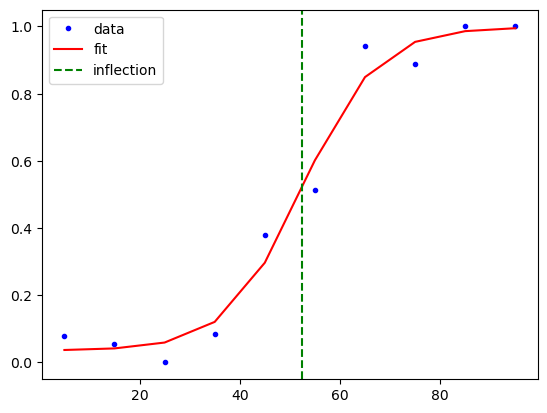

Seuil d'inflexion pour les données 13 : 46.97090448407191


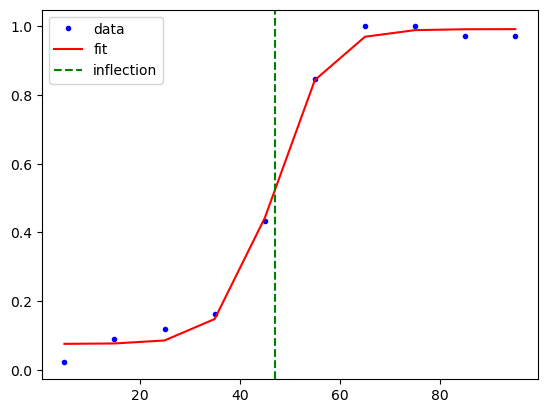

Seuil d'inflexion pour les données 14 : 50.91683141013044


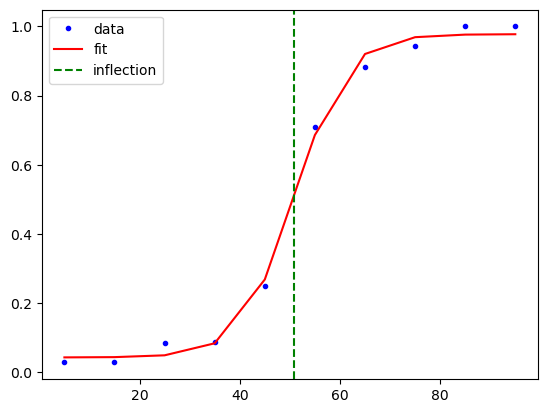

Seuil d'inflexion pour les données 15 : 34.594406651846434


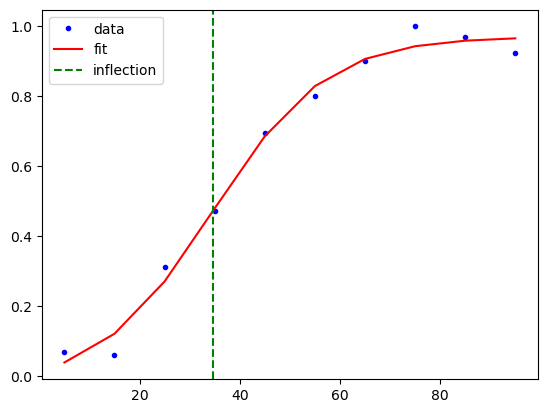

Seuil d'inflexion pour les données 16 : 51.514325933753554


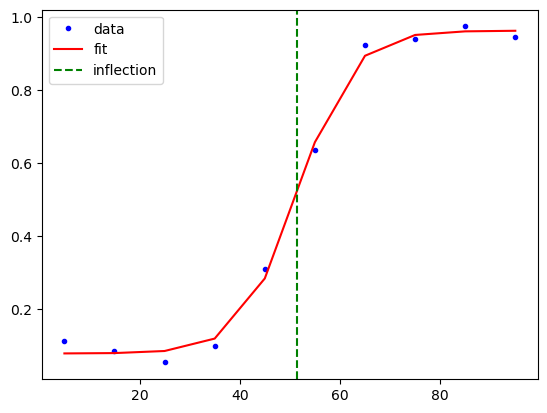

Seuil d'inflexion pour les données 17 : 42.337017867998355


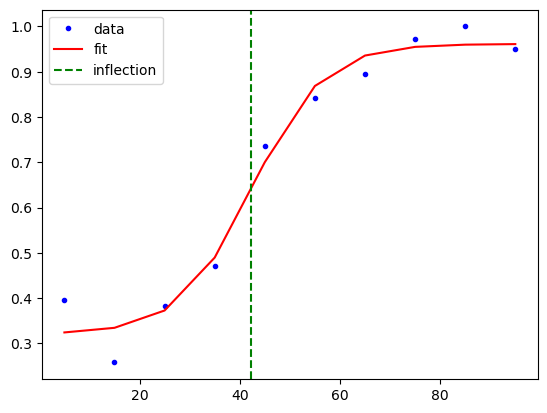

Seuil d'inflexion pour les données 18 : 53.56156318314507


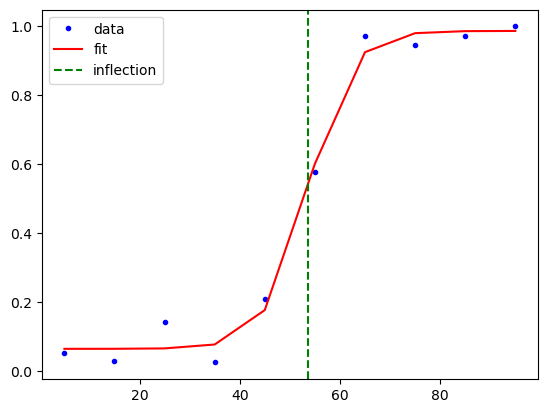

Seuil d'inflexion pour les données 19 : 49.547561533414346


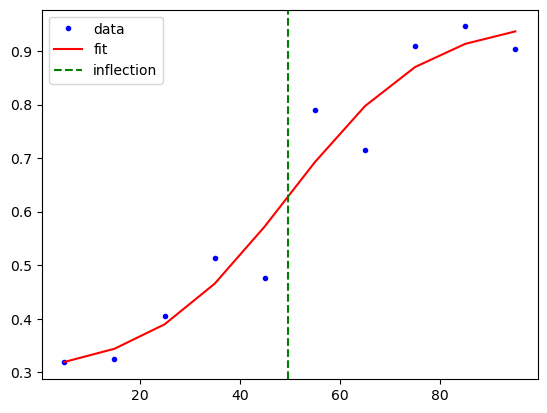

Seuil d'inflexion pour les données 20 : 45.40480648910708


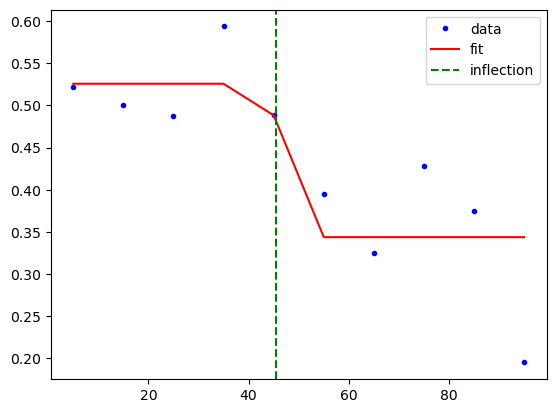

Seuil d'inflexion pour les données 21 : 59.42121603875495


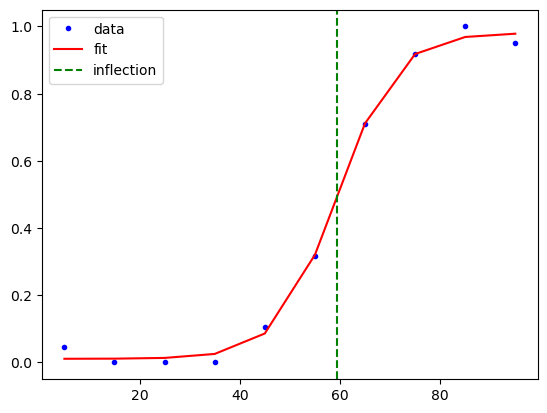

Seuil d'inflexion pour les données 22 : 52.46521801690734


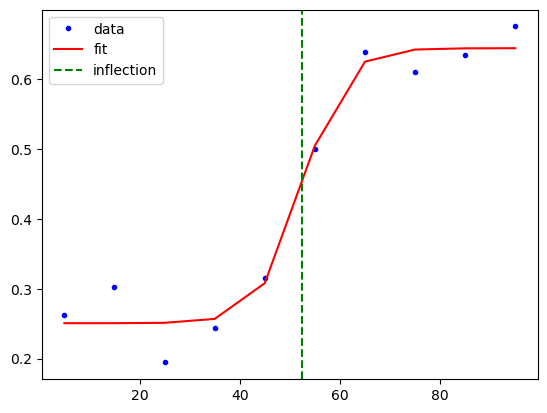

Seuil d'inflexion pour les données 23 : 59.82849868299966


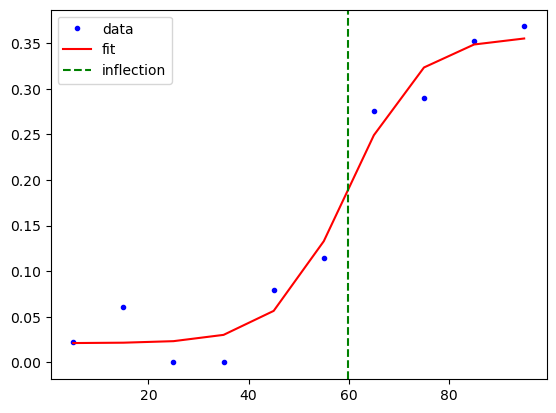

Seuil d'inflexion pour les données 24 : 55.358224329796656


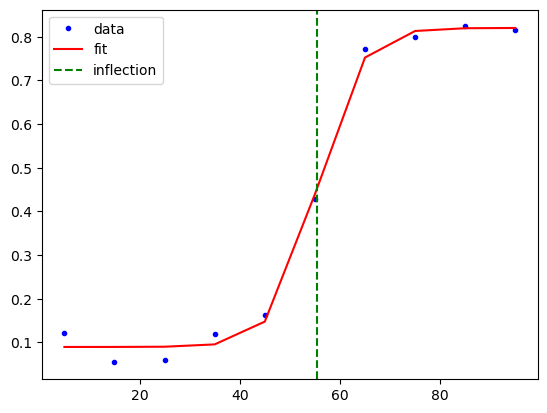

Seuil d'inflexion pour les données 25 : 60.76260798964514


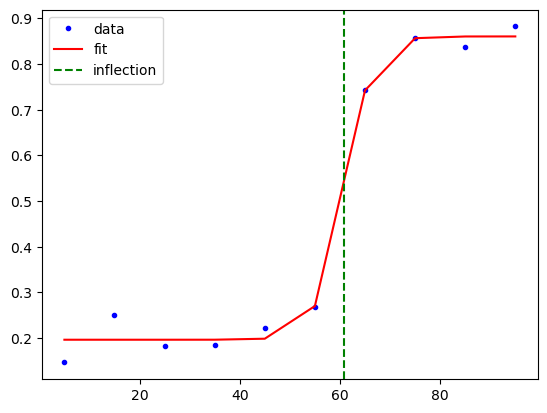

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# définir la fonction sigmoidale
def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y

# définir la fonction pour calculer le seuil d'inflexion
def inflection_point(L, x0):
    return x0

# boucle sur les données pour chaque i
for i in range (1,26):
    # récupérer les données
    results = view_results(i, return_data=True, do_plot=False)
    xdata = np.linspace(5, 95, 10)
    ydata = results['response']['mean']

    # ajuster la fonction sigmoidale aux données
    p0 = [max(ydata), np.median(xdata), 1, min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0)

    # calculer le seuil d'inflexion
    inflection = inflection_point(*popt[0:2])   # décompresser les deux premiers éléments de la liste popt en tant qu'arguments pour la fonction "inflection_poin
    print('Seuil d\'inflexion pour les données', i, ':', inflection)

    # tracer les données et la courbe ajustée
    plt.plot(xdata, ydata, 'b.', label='data')
    plt.plot(xdata, sigmoid(xdata, *popt), 'r-', label='fit')
    plt.axvline(inflection, color='g', linestyle='--', label='inflection')
    plt.legend()
    plt.show()
     plt.savefig(f'subject_{i}.png')








In [ ]:
save fig()


In [2]:
import pandas
labels=pandas.read_csv(f'./labels/labels_1.csv')
labels

,run,trial,global time,run time,morph level,couple,response,response time
0,1,1,35172,847,15,4,1,558.0
1,1,2,40374,6049,95,1,1,846.0
2,1,3,45376,11051,75,9,1,843.0
3,1,4,49378,15053,5,2,0,NaN
4,1,5,55281,20956,45,7,1,888.0
...,...,...,...,...,...,...,...,...
365,4,88,2255587,462333,95,7,1,612.0
366,4,89,2259489,466235,25,6,1,507.0
367,4,90,2265591,472337,55,5,0,NaN
368,4,91,2265591,472337,55,5,0,NaN


In [7]:
import pandas
labels=pandas.read_csv(f'./labels/labels_2.csv')
labels

,run,trial,global time,run time,morph level,couple,response,response time
0,1,1,592728,1625,45,3,1,615.0
1,1,2,596230,5127,75,7,1,936.0
2,1,3,602215,11112,55,1,1,514.0
3,1,4,607118,16015,55,6,1,539.0
4,1,5,616822,25719,5,5,0,NaN
...,...,...,...,...,...,...,...,...
365,4,92,2784781,462385,95,9,1,516.0
366,4,93,2788682,466286,85,9,1,563.0
367,4,94,2793384,470988,85,9,1,854.0
368,4,95,2793384,470988,85,9,0,NaN


In [10]:
labels["couple"].values

array([3, 7, 1, 6, 5, 4, 6, 1, 1, 3, 9, 2, 5, 6, 8, 2, 9, 8, 2, 4, 5, 4,
       8, 4, 2, 3, 9, 3, 5, 7, 4, 7, 6, 4, 2, 1, 9, 3, 1, 5, 9, 1, 1, 9,
       2, 2, 1, 4, 7, 1, 6, 7, 9, 6, 8, 2, 6, 5, 7, 3, 7, 4, 6, 2, 6, 8,
       9, 9, 3, 3, 8, 1, 2, 5, 8, 6, 4, 3, 9, 8, 3, 2, 5, 4, 8, 7, 9, 4,
       7, 2, 4, 4, 7, 9, 7, 5, 5, 6, 7, 4, 9, 5, 1, 1, 9, 5, 1, 1, 2, 6,
       8, 3, 4, 6, 8, 8, 4, 4, 2, 4, 8, 2, 3, 8, 8, 7, 2, 4, 3, 8, 7, 7,
       6, 7, 9, 6, 8, 3, 2, 3, 5, 7, 2, 1, 6, 7, 6, 6, 5, 3, 6, 3, 1, 6,
       9, 1, 9, 5, 8, 5, 5, 8, 9, 5, 3, 2, 1, 5, 2, 1, 7, 4, 8, 3, 5, 3,
       7, 9, 7, 9, 5, 5, 9, 4, 6, 4, 3, 2, 1, 4, 9, 7, 1, 5, 7, 6, 4, 9,
       2, 1, 6, 9, 2, 1, 6, 3, 4, 3, 4, 6, 7, 3, 8, 1, 6, 5, 4, 4, 5, 8,
       2, 1, 2, 2, 3, 2, 5, 3, 2, 5, 7, 5, 5, 9, 4, 8, 1, 6, 1, 8, 9, 7,
       3, 3, 7, 1, 5, 7, 9, 6, 5, 8, 3, 1, 1, 8, 9, 6, 8, 7, 7, 1, 9, 8,
       1, 2, 8, 1, 3, 5, 2, 4, 4, 4, 2, 5, 3, 9, 8, 4, 5, 8, 5, 6, 8, 2,
       6, 6, 8, 2, 1, 7, 5, 2, 8, 9, 9, 9, 7, 4, 6,

In [20]:
import pandas
labels=pandas.read_csv(f'./labels/labels_2.csv')
labels

,run,trial,global time,run time,morph level,couple,response,response time
0,1,1,592728,1625,45,3,1,615.0
1,1,2,596230,5127,75,7,1,936.0
2,1,3,602215,11112,55,1,1,514.0
3,1,4,607118,16015,55,6,1,539.0
4,1,5,616822,25719,5,5,0,NaN
...,...,...,...,...,...,...,...,...
365,4,92,2784781,462385,95,9,1,516.0
366,4,93,2788682,466286,85,9,1,563.0
367,4,94,2793384,470988,85,9,1,854.0
368,4,95,2793384,470988,85,9,0,NaN


In [21]:
import pandas
labels=pandas.read_csv(f'./labels/labels_5.csv')
labels

,run,trial,global time,run time,morph level,couple,response,response time
0,1,1,1229331,1635,45,3,0,NaN
1,1,2,1232833,5137,75,7,0,NaN
2,1,3,1238835,11139,55,1,1,764.0
3,1,4,1243738,16042,55,6,1,1689.0
4,1,5,1253458,25762,5,5,0,NaN
...,...,...,...,...,...,...,...,...
365,4,92,3422099,462434,95,9,1,750.0
366,4,93,3426000,466335,85,9,1,840.0
367,4,94,3430702,471037,85,9,1,727.0
368,4,95,3430702,471037,85,9,0,NaN


In [24]:
labels["couple"].values

array([3, 7, 1, 6, 5, 4, 6, 1, 1, 3, 9, 2, 5, 6, 8, 2, 9, 8, 2, 4, 5, 4,
       8, 4, 2, 3, 9, 3, 5, 7, 4, 7, 6, 4, 2, 1, 9, 3, 1, 5, 9, 1, 1, 9,
       2, 2, 1, 4, 7, 1, 6, 7, 9, 6, 8, 2, 6, 5, 7, 3, 7, 4, 6, 2, 6, 8,
       9, 9, 3, 3, 8, 1, 2, 5, 8, 6, 4, 3, 9, 8, 3, 2, 5, 4, 8, 7, 9, 4,
       7, 2, 4, 4, 7, 9, 7, 5, 5, 6, 7, 4, 9, 5, 1, 1, 9, 5, 1, 1, 2, 6,
       8, 3, 4, 6, 8, 8, 4, 4, 2, 4, 8, 2, 3, 8, 8, 7, 2, 4, 3, 8, 7, 7,
       6, 7, 9, 6, 8, 3, 2, 3, 5, 7, 2, 1, 6, 7, 6, 6, 5, 3, 6, 3, 1, 6,
       9, 1, 9, 5, 8, 5, 5, 8, 9, 5, 3, 2, 1, 5, 2, 1, 7, 4, 8, 3, 5, 3,
       7, 9, 7, 9, 5, 5, 9, 4, 6, 4, 3, 2, 1, 4, 9, 7, 1, 5, 7, 6, 4, 9,
       2, 1, 6, 9, 2, 1, 6, 3, 4, 3, 4, 6, 7, 3, 8, 1, 6, 5, 4, 4, 5, 8,
       2, 1, 2, 2, 3, 2, 5, 3, 2, 5, 7, 5, 5, 9, 4, 8, 1, 6, 1, 8, 9, 7,
       3, 3, 7, 1, 5, 7, 9, 6, 5, 8, 3, 1, 1, 8, 9, 6, 8, 7, 7, 1, 9, 8,
       1, 2, 8, 1, 3, 5, 2, 4, 4, 4, 2, 5, 3, 9, 8, 4, 5, 8, 5, 6, 8, 2,
       6, 6, 8, 2, 1, 7, 5, 2, 8, 9, 9, 9, 7, 4, 6,

In [27]:
import pandas as pd

labels = pd.read_csv('labels/labels_1.csv')
Z1 = labels[labels['couple'] == 1]
print(couple_1_rows)

     run  trial  global time  run time  morph level  couple  response  \
1      1      2        40374      6049           95       1         1   
12     1     13        92078     57753           45       1         0   
21     1     22       140448    106123           55       1         0   
41     1     42       240872    206547           35       1         1   
57     1     58       327657    293332           85       1         1   
61     1     62       347948    313623           25       1         1   
67     1     68       376043    341718           15       1         1   
74     1     75       414426    380101           55       1         1   
75     1     76       419911    385586            5       1         1   
83     1     84       462628    428303           45       1         0   
86     1     87       476334    442009           95       1         1   
90     1     91       495241    460916           65       1         1   
94     2      1       608155       434           75

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def view_results(subject=1, run='all', return_data=False,do_plot=True):

    labels = pd.read_csv(f'labels/labels_{subject}.csv')
    
    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
        t = labels['couple']
    elif run in range(1, 5):
        mask = labels['run'] == run
        x = labels[mask]['morph level']
        y = labels[mask]['response']
        z = labels[mask]['response time']
        t = labels[mask]['couple']
    
    # Subset data to couple 1
    mask_couple_1 = (t == 1)
    x_couple_1 = x[mask_couple_1]
    y_couple_1 = y[mask_couple_1]

    # Calculate means and standard errors
    values, counts = np.unique(x_couple_1, return_counts=True)
    response_mean = np.zeros(len(values))
    response_std = np.zeros(len(values))
    for count, v in enumerate(values):
        mask = (x_couple_1 == v)
        response_mean[count] = np.nan_to_num(np.mean(y_couple_1[mask]))
        response_std[count] = np.nan_to_num(np.std(y_couple_1[mask]) / np.sqrt(np.sum(mask)))

    # Plot graph
    
    plt.ylabel('Response')
    plt.legend()
    plt.show()

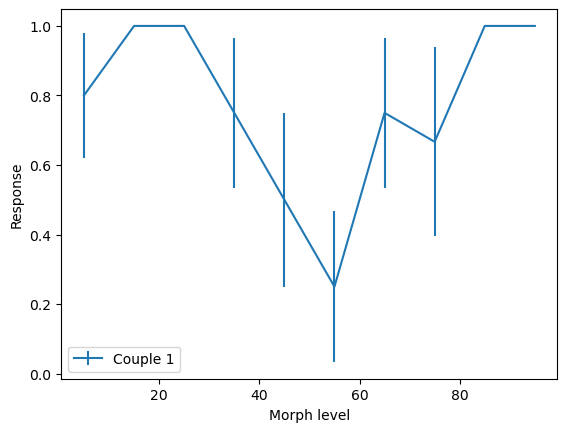

In [33]:
view_results(1,'all',return_data=True,do_plot=True)

In [ ]:
def view_results(subject=1, run='all', return_data=False,do_plot=True):

    labels = pd.read_csv(f'labels/labels_{subject}.csv')
    
    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
        t = labels['couple']
    elif run in range(1, 5):
        mask = labels['run'] == run
        x = labels[mask]['morph level']
        y = labels[mask]['response']
        z = labels[mask]['response time']
        t = labels[mask]['couple']
    
    # Subset data to couple 1
    mask_couple_1 = (t == 1)
    x_couple_1 = x[mask_couple_1]
    y_couple_1 = y[mask_couple_1]

    # Calculate means and standard errors
    values, counts = np.unique(x_couple_1, return_counts=True)
    response_mean = np.zeros(len(values))
    response_std = np.zeros(len(values))
    for count, v in enumerate(values):
        mask = (x_couple_1 == v)
        response_mean[count] = np.nan_to_num(np.mean(y_couple_1[mask]))
        response_std[count] = np.nan_to_num(np.std(y_couple_1[mask]) / np.sqrt(np.sum(mask)))

    # Plot graph
    plt.plot(values, response_mean, label='Couple 1')
    plt.errorbar(values, response_mean, yerr=response_std, fmt='none', label=None)
    plt.xlabel('Morph Level')
    plt.ylabel('Response')
    plt.legend()
    plt.show()

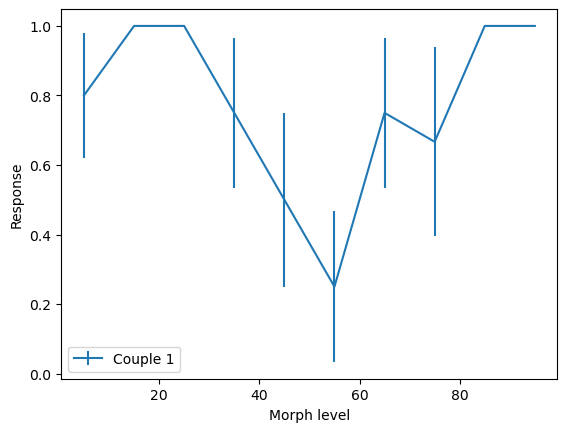

In [34]:
view_results(1,'all',return_data=True,do_plot=True)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def view_results(subject=1, run='all', return_data=False, do_plot=True):

    labels = pd.read_csv(f'labels/labels_{subject}.csv')

    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
        t = labels['couple']
    elif run in range(1, 5):
        mask = labels['run'] == run
        x = labels[mask]['morph level']
        y = labels[mask]['response']
        z = labels[mask]['response time']
        t = labels[mask]['couple']

    # Plot graph for each couple
    for couple in range(1, 10):
        mask_couple = (t == couple)
        x_couple = x[mask_couple]
        y_couple = y[mask_couple]

        # Calculate means and standard errors
        values, counts = np.unique(x_couple, return_counts=True)
        response_mean = np.zeros(len(values))
        response_std = np.zeros(len(values))
        for count, v in enumerate(values):
            mask = (x_couple == v)
            response_mean[count] = np.nan_to_num(np.mean(y_couple[mask]))
            response_std[count] = np.nan_to_num(np.std(y_couple[mask]) / np.sqrt(np.sum(mask)))

        # Plot graph
        plt.figure()
        plt.errorbar(values, response_mean, yerr=response_std, fmt='-o')
        plt.xlabel('Morph level')
        plt.ylabel('Response')
        plt.title(f'Couple {couple}')
        plt.show()

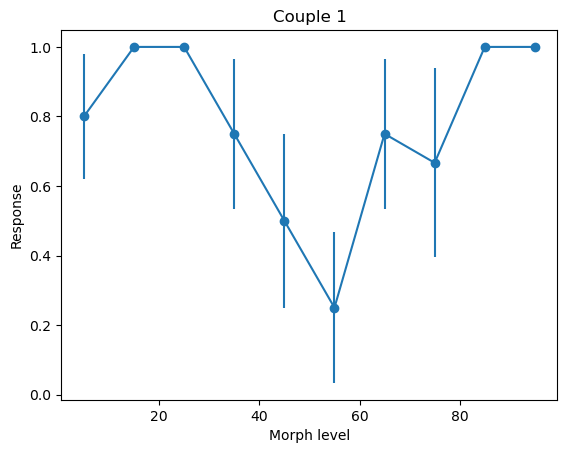

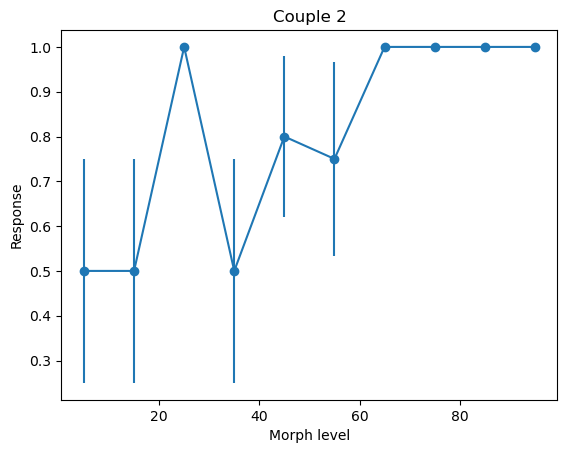

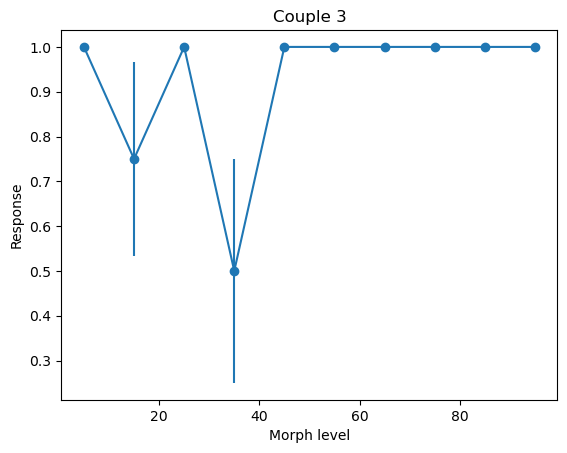

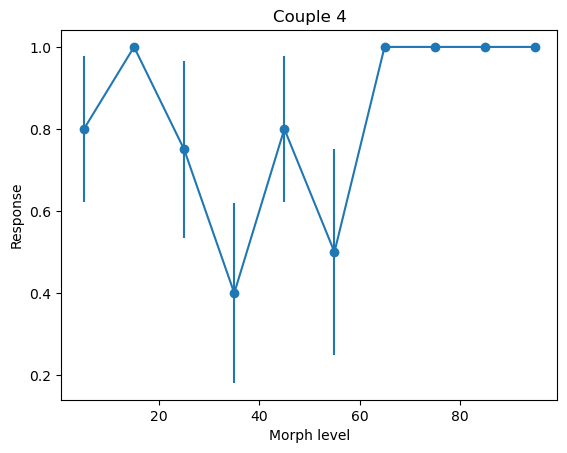

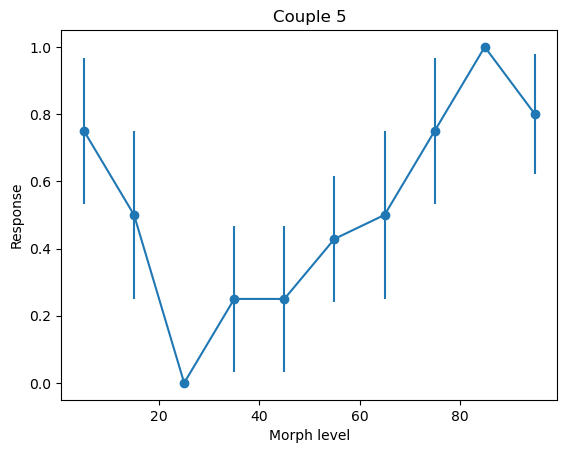

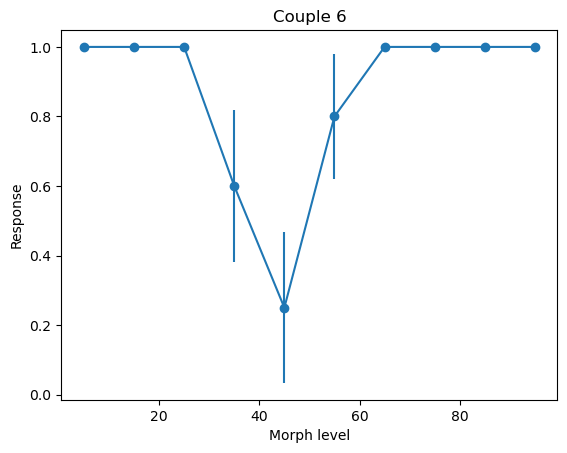

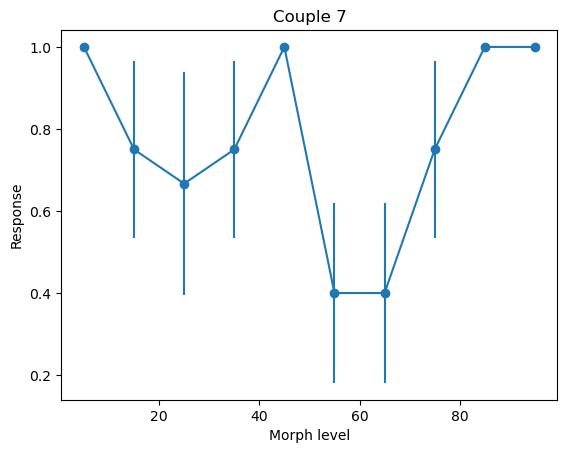

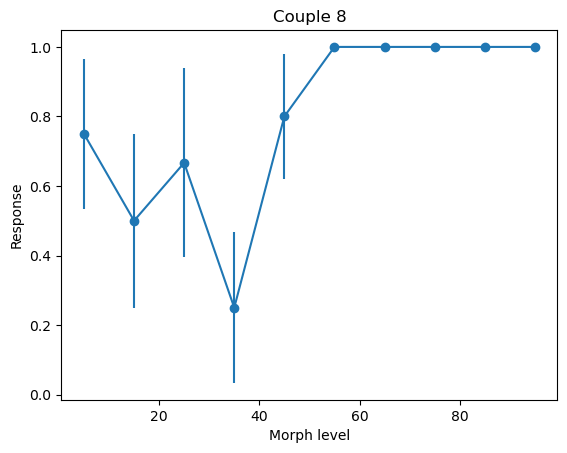

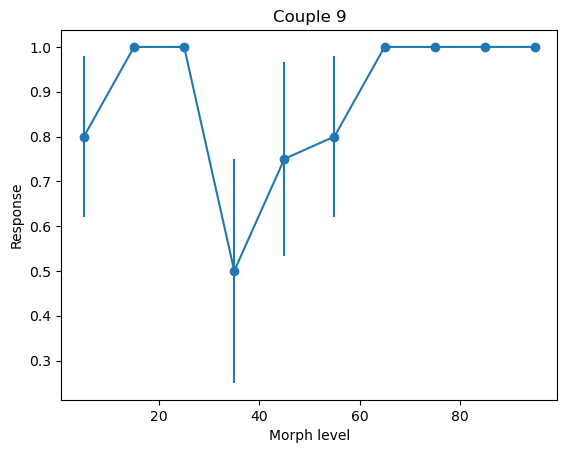

In [37]:
view_results(1,'all',return_data=True,do_plot=True)

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def view_results(subject=1, run='all', return_data=False, do_plot=True):

    labels = pd.read_csv(f'labels/labels_{subject}.csv')

    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
        t = labels['couple']
    elif run in range(1, 5):
        mask = labels['run'] == run
        x = labels[mask]['morph level']
        y = labels[mask]['response']
        z = labels[mask]['response time']
        t = labels[mask]['couple']

    # Calculate means and standard errors for all couples
    values, counts = np.unique(x, return_counts=True)
    response_mean = np.zeros((9, len(values)))
    response_std = np.zeros((9, len(values)))
    for couple in range(1, 10):
        mask_couple = (t == couple)
        x_couple = x[mask_couple]
        y_couple = y[mask_couple]

        for count, v in enumerate(values):
            mask = (x_couple == v)
            response_mean[couple-1, count] = np.nan_to_num(np.mean(y_couple[mask]))
            response_std[couple-1, count] = np.nan_to_num(np.std(y_couple[mask]) / np.sqrt(np.sum(mask)))

    # Plot graph
    plt.figure()
    for couple in range(1, 10):
        plt.errorbar(values, response_mean[couple-1,:], yerr=response_std[couple-1,:], fmt='-o', label=f'Couple {couple}')
    plt.xlabel('Morph level')
    plt.ylabel('Response')
    plt.legend()
    plt.show()

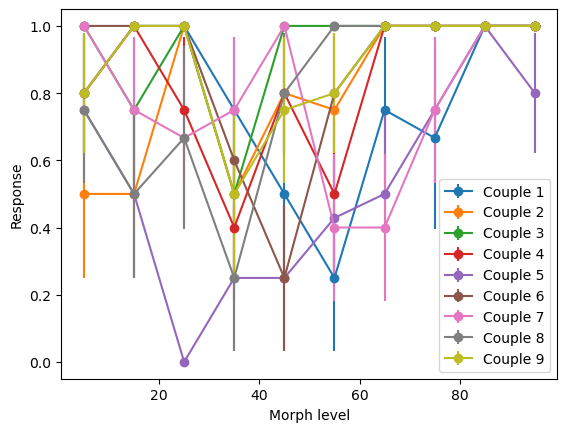

In [42]:
view_results(1,'all',return_data=True,do_plot=True)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def view_results(subject=1, run='all', return_data=False, do_plot=True):

    labels = pd.read_csv(f'labels/labels_{subject}.csv')

    if run == 'all':
        x = labels['morph level']
        y = labels['response']
        z = labels['response time']
        t = labels['couple']
    elif run in range(1, 5):
        mask = labels['run'] == run
        x = labels[mask]['morph level']
        y = labels[mask]['response']
        z = labels[mask]['response time']
        t = labels[mask]['couple']

    # Plot graph for each couple
    for couple in range(1, 10):
        mask_couple = (t == couple)
        x_couple = x[mask_couple]
        y_couple = y[mask_couple]

        # Calculate means and standard errors
        values, counts = np.unique(x_couple, return_counts=True)
        response_mean = np.zeros(len(values))
        response_std = np.zeros(len(values))
        for count, v in enumerate(values):
            mask = (x_couple == v)
            response_mean[count] = np.nan_to_num(np.mean(y_couple[mask]))
            response_std[count] = np.nan_to_num(np.std(y_couple[mask]) / np.sqrt(np.sum(mask)))

        # Interpolate data points
        f = interp1d(values, response_mean, kind='cubic')
        x_smooth = np.linspace(values.min(), values.max(), 100)
        y_smooth = f(x_smooth)

        # Plot graph with smoothed curve
        plt.figure()
        plt.plot(x_smooth, y_smooth)
        plt.errorbar(values, response_mean, yerr=response_std, fmt='o')
        plt.xlabel('Morph level')
        plt.ylabel('Response')
        plt.title(f'Couple {couple}')
        plt.show()

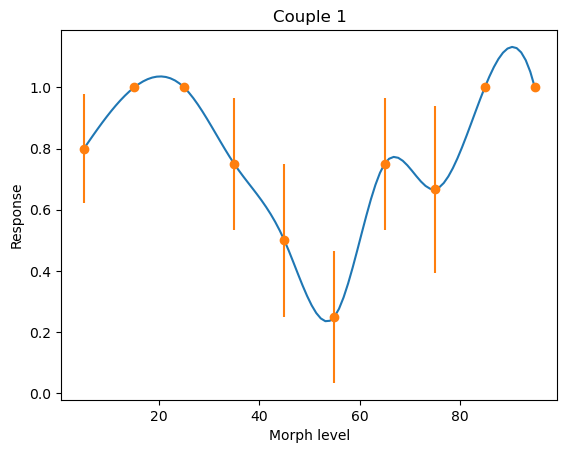

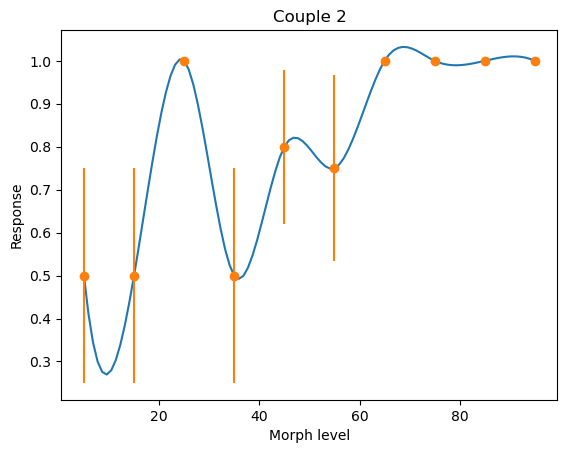

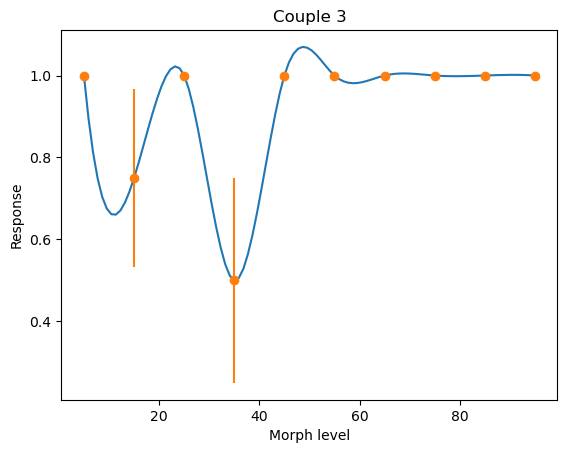

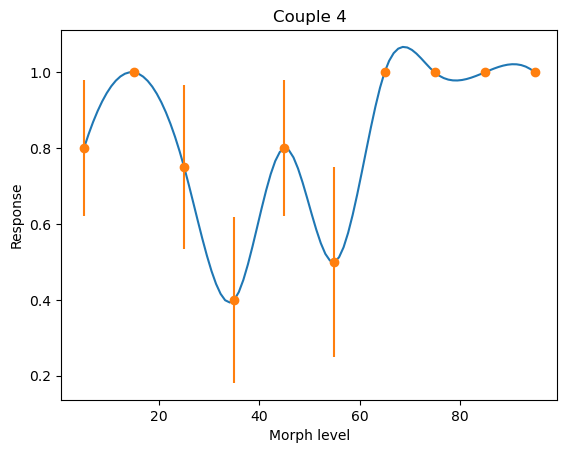

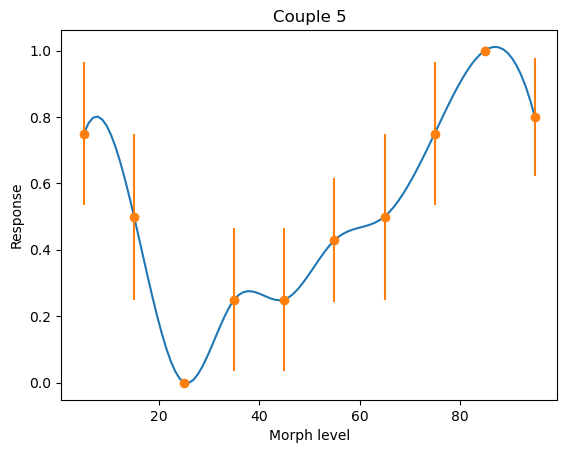

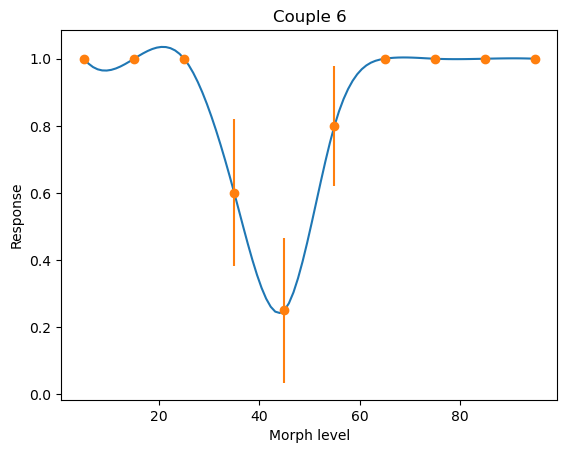

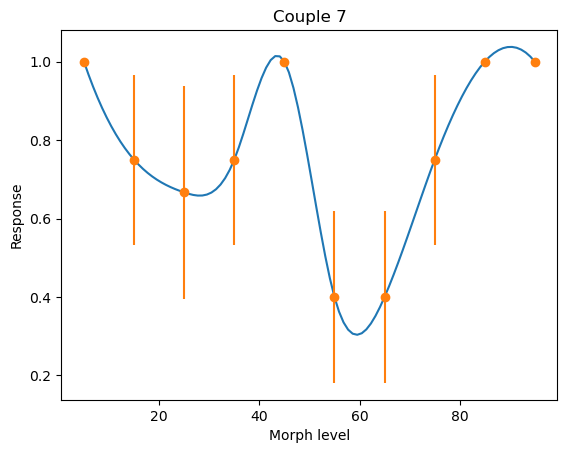

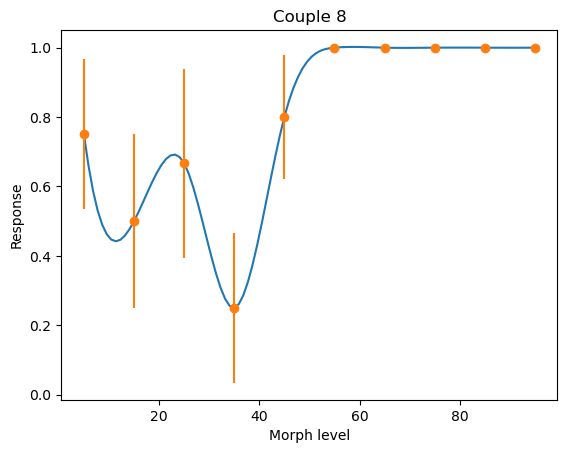

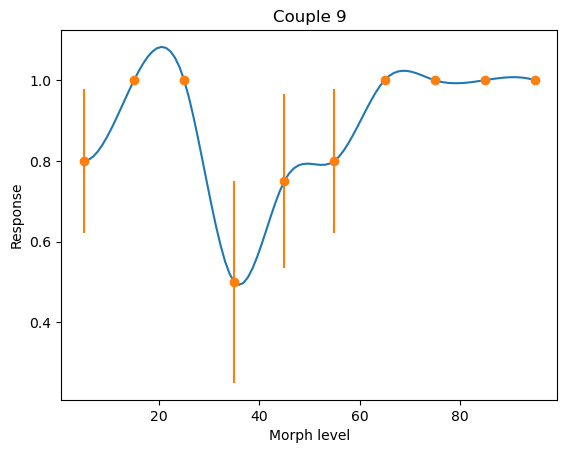

In [45]:
view_results(1,'all',return_data=True,do_plot=True)

In [51]:
def view_results(subject=1, run='all', return_data=False, do_plot=True):
    labels = pd.read_csv(f'labels/labels_{subject}.csv')
    fig, ax = plt.subplots()
    for couple in range(1, 10):
        mask_couple = (labels['couple'] == couple)
        x_couple = labels[mask_couple]['morph level']
        y_couple = labels[mask_couple]['response']
        # Calculate means and standard errors
        values, counts = np.unique(x_couple, return_counts=True)
        response_mean = np.zeros(len(values))
        response_std = np.zeros(len(values))
        for count, v in enumerate(values):
            mask = (x_couple == v)
            response_mean[count] = np.nan_to_num(np.mean(y_couple[mask]))
            response_std[count] = np.nan_to_num(np.std(y_couple[mask]) / np.sqrt(np.sum(mask)))
        # Interpolate data points
        f = interp1d(values, response_mean, kind='cubic')
        x_smooth = np.linspace(values.min(), values.max(), 100)
        y_smooth = f(x_smooth)
        # Add curve to the plot
        ax.plot(x_smooth, y_smooth, label=f'Couple {couple}')
    ax.set_xlabel('Morph level')
    ax.set_ylabel('Response')
    ax.legend()
    plt.show()

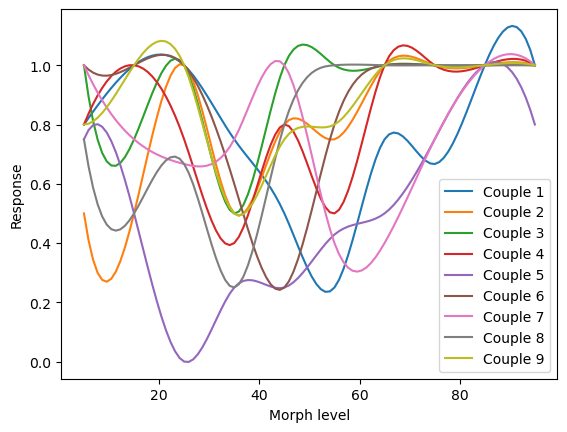

In [52]:
view_results(1,'all',return_data=True,do_plot=True)